In [1]:
import pandas as pd
import numpy as np
   
tourney_df = pd.read_csv("data/data.csv", index_col=0)
tourney_df.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,avg_blk0,avg_blk1,std_blk0,std_blk1,avg_pf0,avg_pf1,std_pf0,std_pf1,ftr0,ftr1
0,2003,134,1421,92,1411,84,N,1,32,69,...,2.23,3.00,1.72,1.65,18.30,19.10,4.56,3.69,0.53,0.38
1,2003,136,1112,80,1436,51,N,0,31,66,...,4.21,2.97,2.01,1.72,17.75,15.90,2.99,4.05,0.39,0.36
2,2003,136,1113,84,1272,71,N,0,31,59,...,4.24,5.07,2.94,3.16,19.41,18.76,3.25,4.34,0.47,0.40
3,2003,136,1141,79,1166,73,N,0,29,53,...,4.45,4.00,2.22,2.35,17.27,20.97,3.12,4.81,0.35,0.48
4,2003,136,1143,76,1301,74,N,1,27,64,...,2.79,3.07,1.63,2.49,17.10,18.67,3.74,4.21,0.35,0.39


# Choosing Features to Use for Model

Edit featureList below to use any of the features in the data frame above (see above for names of columns).  

In [2]:
teamfList = []
teamfList.append('wins')
featureList = []
for f in teamfList:
    featureList.append(f+'0')
    featureList.append(f+'1')
#for f in ['fgm', 'fga', 'fgm3', 'fga3', 'ftm', 'fta', 'or', 'dr', 'ast', 'to', 'stl', 'blk', 'pf']:
#    for mod in ['avg_', 'std_']:
#        featureList.append(mod+f+'0')
#        featureList.append(mod+f+'1')
print("Feature list = {0}".format(featureList))

Feature list = ['wins0', 'wins1']


In [3]:
y = tourney_df['team0Win'].values # results
X = tourney_df[featureList].values # features

In [4]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [5]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
print("Means = {0}, Stdevs = {1}".format(scaler.mean_, scaler.scale_))

Means = [ 23.83899557  24.01033973], Stdevs = [ 3.76162904  3.67130427]


/Users/dtamayo/miniconda2/envs/ml2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/Users/dtamayo/miniconda2/envs/ml2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/dtamayo/miniconda2/envs/ml2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Train our model!

In [28]:
from sklearn import svm
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV

C_range = np.logspace(0, 0, 1)
gamma_range = np.logspace(-5, 1, 50)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(probability=True, kernel='rbf'), scoring="log_loss", param_grid=param_grid, cv=cv, n_jobs=-1)
grid.fit(X_train, y_train) 
print "The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_) 

The best parameters are {'C': 1.0, 'gamma': 0.0037275937203149379} with a score of -0.61


In [29]:
model = grid.best_estimator_
y_pred = model.predict_proba(X_test) # probability that team0 wins (what Kaggle calls team 1, and wants for submission)
from sklearn import metrics
print("Log loss is {0}".format(metrics.log_loss(y_test, y_pred)))

Log loss is 0.619494867198


In [14]:
from sklearn import svm
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
#C_range = np.logspace(0, 3, 4)
#gamma_range = np.logspace(-3,0,4)
classifiers = []
for C in C_range:
    for gamma in gamma_range:
        clf = svm.SVC(probability=True, kernel='rbf',C=C, gamma=gamma)
        clf.fit(X_train, y_train)
        classifiers.append((C, gamma, clf))

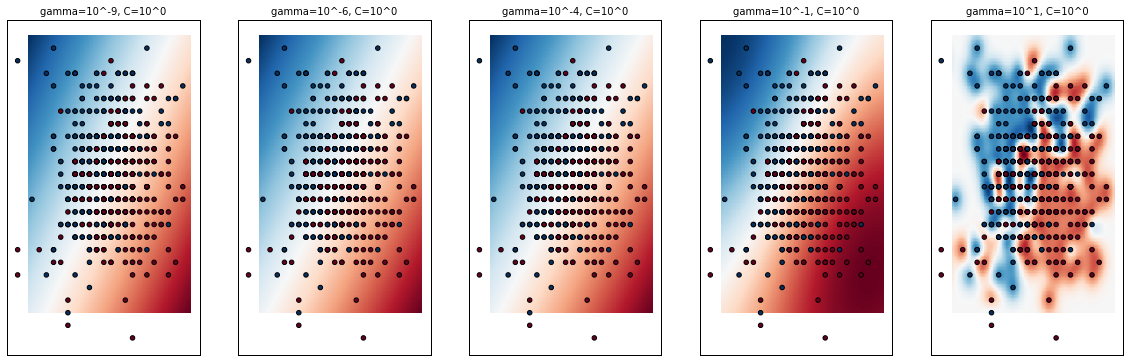

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_range), len(gamma_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

In [17]:
scores = np.fabs([x[1] for x in grid.grid_scores_])
#scores = np.array(scores).reshape(len(C_range), len(gamma_range))
print(scores)

[ 0.63461447  0.63622026  0.6139316   0.61543081  0.6755386 ]


In [19]:
print(gamma_range)

[  1.00000000e-09   3.16227766e-07   1.00000000e-04   3.16227766e-02
   1.00000000e+01]


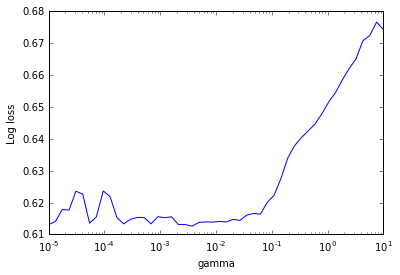

In [30]:
scores = np.fabs([x[1] for x in grid.grid_scores_])

plt.figure(figsize=(8, 6))
fig, ax = plt.subplots()
ax.plot(gamma_range, scores)
ax.set_xscale('log')
ax.set_xlabel('gamma')
ax.set_ylabel('Log loss')
plt.show()

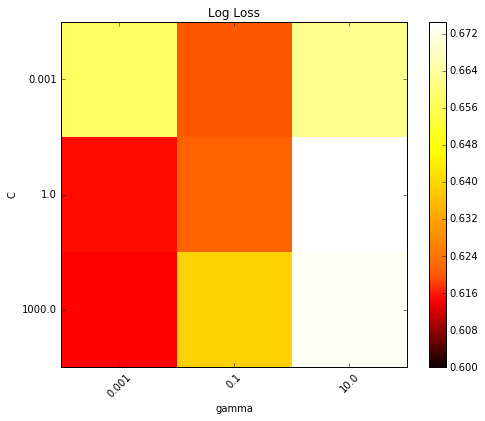

In [11]:
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

    
# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
# We extract just the scores
scores = np.fabs([x[1] for x in grid.grid_scores_])
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.6, midpoint=0.62))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Log Loss')
plt.show()